<a href="https://colab.research.google.com/github/osjayaprakash/deeplearning/blob/main/transformer_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Flatten,
                                     Dense, GRU, Embedding, Bidirectional,
                                     TimeDistributed, Concatenate, RepeatVector, LSTM, MultiHeadAttention, LayerNormalization, Add, Dropout )
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import matplotlib.pyplot as plt
import platform
import sys
import pandas as pd
import sklearn as sk
import scipy as sp
from tensorflow.python.ops.numpy_ops import np_config  
import einops

np_config.enable_numpy_behavior()
tf.config.experimental.list_physical_devices('GPU')
print(f"Python Platform: {platform.platform()}")
print(f"Tensor Flow Version: {tf.__version__}")
#print(f"Keras Version: {tf.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print(f"SciPy {sp.__version__}")
print(tf.config.list_physical_devices())

Python Platform: Linux-5.15.0-1044-aws-x86_64-with-glibc2.29
Tensor Flow Version: 2.13.1

Python 3.8.10 (default, Nov  7 2024, 13:10:47) 
[GCC 9.4.0]
Pandas 2.0.3
Scikit-Learn 1.3.2
SciPy 1.10.1
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [39]:
import kagglehub

# Download latest version
root_dir = kagglehub.dataset_download("shahrukhkhan/im2latex100k")
# path = kagglehub.dataset_download("gregoryeritsyan/im2latex-230k")

print("Path to dataset files:", root_dir)

Path to dataset files: /home/ubuntu/.cache/kagglehub/datasets/shahrukhkhan/im2latex100k/versions/7


# Preprocess

In [112]:
IMG_SHAPE = [50, 200, 1]
EMBEDDING_DIM = 256
max_seq_length = 250
n = 50000
max_seq_len_1 = max_seq_length - 1

In [113]:
def preprocess_image(image):
    """Preprocess the input image: Resize and normalize."""
    image = tf.image.resize(image, (50, 200))  # Resize to (50, 200)
    image = image / 255.0  # Normalize to [0, 1]
    return image

def load_and_preprocess_images(image_paths):
    """Load and preprocess a batch of images."""
    # Use Gray scale
    images = [preprocess_image(tf.io.decode_image(tf.io.read_file(path), channels=1))
              for path in image_paths]
    return tf.stack(images)

def prepare_sequences(latex_texts, max_seq_length):
    """Convert LaTeX texts to padded sequences of tokens."""
    sequences = [text_to_sequence(text) for text in latex_texts]
    return pad_sequences(sequences, maxlen=max_seq_length, padding='post')


In [114]:
# %%time
# %%prun

df = pd.read_csv(f"{root_dir}/im2latex_train.csv", nrows=n)

train_image_paths = []
train_latex_texts = []

for index, row in df.iterrows():
    train_image_paths += [f"{root_dir}//formula_images_processed/formula_images_processed/{row.image}"]
    train_latex_texts += ["[START] " + row.formula + " [END]"]

train_images = load_and_preprocess_images(train_image_paths)

## Transformer Model

In [254]:
tokenizer = tf.keras.layers.TextVectorization(max_tokens=None, standardize = None)

In [255]:
tokenizer.adapt(train_latex_texts)

In [256]:
latex_labels = tokenizer(train_latex_texts)
train_sequences = np.asarray(latex_labels)
#input_labels = train_sequences[..., :-1]
#output_labels = train_sequences[..., 1:]

In [257]:
print(latex_labels.shape)
print(train_images.shape)
vocab_dict = {name: id for id, name in enumerate(tokenizer.get_vocabulary())}
print(vocab_dict)

(50000, 152)
(50000, 50, 200, 1)
{'': 0, '[UNK]': 1, '}': 2, '{': 3, '_': 4, '^': 5, '2': 6, '(': 7, ')': 8, '=': 9, '1': 10, '-': 11, ',': 12, '[START]': 13, '[END]': 14, '\\frac': 15, '+': 16, 'i': 17, '0': 18, 'x': 19, 'n': 20, '.': 21, '\\,': 22, 'd': 23, 'a': 24, '\\mu': 25, 'e': 26, 'k': 27, 'm': 28, 'c': 29, 'r': 30, 'p': 31, '\\partial': 32, '\\alpha': 33, 't': 34, 'A': 35, '~': 36, '\\;': 37, 'j': 38, 's': 39, '3': 40, 'l': 41, '\\right)': 42, '\\left(': 43, 'g': 44, '4': 45, '\\': 46, '\\nu': 47, '\\prime': 48, '\\pi': 49, 'b': 50, 'z': 51, '\\phi': 52, '|': 53, '\\mathrm': 54, '\\cal': 55, '\\delta': 56, 'f': 57, 'N': 58, '\\lambda': 59, 'T': 60, 'q': 61, 'S': 62, '\\beta': 63, ']': 64, '[': 65, 'R': 66, '\\bar': 67, '\\int': 68, 'L': 69, 'M': 70, 'D': 71, '\\operatorname': 72, 'B': 73, 'F': 74, '\\sigma': 75, 'y': 76, '\\theta': 77, '&': 78, '\\\\': 79, '\\psi': 80, 'h': 81, '/': 82, '\\gamma': 83, '\\hat': 84, '\\sqrt': 85, 'H': 86, '\\sum': 87, '\\rho': 88, '\\tilde': 89,

[START] \varphi _ { 0 } = \left[ \begin{array} { c } { e ^ { - q V ( x ) } } \\ { 0 } \\ \end{array} \right] [END]


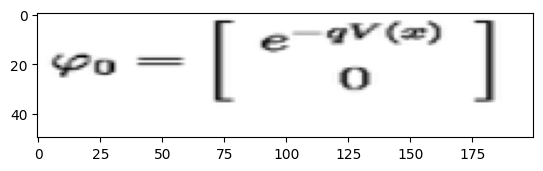

In [258]:
idx = np.random.choice(range(train_images.shape[0]))
img = train_images[idx]
plt.imshow(img.numpy(), cmap="gray")
print(train_latex_texts[idx])

## Transformer Model

In [267]:
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (IMG_SHAPE[0] // patch_size) * (IMG_SHAPE[1] // patch_size)
projection_dim = EMBEDDING_DIM
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]
print(num_patches)

264


In [268]:
class Patches(tf.keras.layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        input_shape = tf.raw_ops.Shape(input=images)
        batch_size = input_shape[0]
        height = input_shape[1]
        width = input_shape[2]
        channels = input_shape[3]
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size
        patches = tf.image.extract_patches(images=images, sizes=[1,self.patch_size, self.patch_size,1], strides=[1,self.patch_size, self.patch_size,1], padding='VALID', rates=[1, 1, 1, 1])
        new_shape = (batch_size, num_patches_h * num_patches_w, self.patch_size * self.patch_size * channels)
        # print(f"PATCHES: {patches.shape}")
        # print(f"RESHAPE: {new_shape}")
        patches = tf.reshape(
            patches,
            shape=new_shape,
        )
        return patches

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config

Image size: (1, 50, 200, 1)
Image size: (1, 50, 200, 1)
Patch size: 6 X 6
Patches per image: 264
Elements per patch: 36


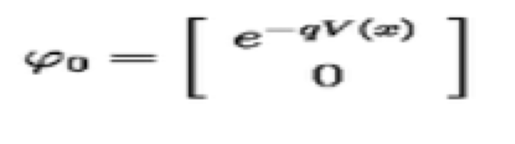

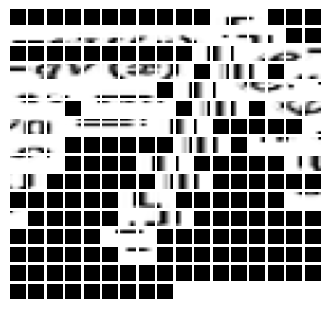

In [274]:
plt.imshow(img.numpy(), cmap="gray")
plt.axis("off")
image = tf.expand_dims(img, axis = 0)

print(f"Image size: {image.shape}")
patches = Patches(patch_size)(image)
print(f"Image size: {image.shape}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1])) +1
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 1))
    plt.imshow(patch_img.numpy(), cmap='gray')
    plt.axis("off")

In [296]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = Dense(units, activation=tf.keras.activations.gelu)(x)
        x = Dropout(dropout_rate)(x)
    return x

In [297]:
class PatchEncoder(tf.keras.layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = Dense(units=projection_dim)
        self.position_embedding = Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.raw_ops.ExpandDims(
           input = tf.experimental.numpy.arange(start=0, stop=self.num_patches, step=1), axis=0
        )
        projected_patches = self.projection(patch)
        #print(projected_patches.shape)
        position_embeddings = self.position_embedding(positions)
        #print(position_embeddings.shape)
        encoded = projected_patches + position_embeddings
        return encoded

    def get_config(self):
        config = super().get_config()
        config.update({"num_patches": self.num_patches})
        return config

In [298]:
def vision_transformer_encoder(input_shape):
    inputs =  Input(shape=input_shape)
    # Create patches.
    patches = Patches(patch_size)(inputs)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.5
        )(x1, x1)
        # Skip connection 1.
        x2 = Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.5)
        # Skip connection 2.
        encoded_patches = tf.keras.layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = LayerNormalization(epsilon=1e-6)(encoded_patches)
    # representation = Flatten()(representation)
    # representation = Dropout(0.2)(representation)
    # Add MLP.
    # features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.2)
    # Classify outputs.
    #logits = tf.keras.layers.Dense(2)(features)
    # Create the Keras model.
    model = tf.keras.Model(inputs=inputs, outputs=representation)
    return model

In [299]:
vit = vision_transformer_encoder(IMG_SHAPE)

In [300]:
vit.summary()

Model: "model_24"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_21 (InputLayer)       [(None, 50, 200, 1)]         0         []                            
                                                                                                  
 patches_27 (Patches)        (None, 264, 36)              0         ['input_21[0][0]']            
                                                                                                  
 patch_encoder_12 (PatchEnc  (None, 264, 256)             77056     ['patches_27[0][0]']          
 oder)                                                                                            
                                                                                                  
 layer_normalization_259 (L  (None, 264, 256)             512       ['patch_encoder_12[0][0

### Transformer Decoder

In [301]:
class SeqEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, max_length, depth):
    super().__init__()
    self.pos_embedding = tf.keras.layers.Embedding(input_dim=max_length, output_dim=depth)

    self.token_embedding = tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=depth,
        mask_zero=True)

    self.add = tf.keras.layers.Add()

  def call(self, seq):
    seq = self.token_embedding(seq) # (batch, seq, depth)

    x = tf.range(tf.shape(seq)[1])  # (seq)
    x = x[tf.newaxis, :]  # (1, seq)
    x = self.pos_embedding(x)  # (1, seq, depth)

    return self.add([seq,x])

In [302]:
class CausalSelfAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    # Use Add instead of + so the keras mask propagates through.
    self.add = tf.keras.layers.Add() 
    self.layernorm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    attn = self.mha(query=x, value=x,
                    use_causal_mask=True)
    x = self.add([x, attn])
    return self.layernorm(x)

In [303]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self,**kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.add = tf.keras.layers.Add() 
    self.layernorm = tf.keras.layers.LayerNormalization()

  def call(self, x, y, **kwargs):
    attn, attention_scores = self.mha(
             query=x, value=y,
             return_attention_scores=True)

    self.last_attention_scores = attention_scores

    x = self.add([x, attn])
    return self.layernorm(x)

In [304]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, units, dropout_rate=0.5):
    super().__init__()
    self.seq = tf.keras.Sequential([
        tf.keras.layers.Dense(units=2*units, activation='relu'),
        tf.keras.layers.Dense(units=units),
        tf.keras.layers.Dropout(rate=dropout_rate),
    ])

    self.layernorm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = x + self.seq(x)
    return self.layernorm(x)

In [305]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, units, num_heads=1, dropout_rate=0.5):
    super().__init__()

    self.self_attention = CausalSelfAttention(num_heads=num_heads,
                                              key_dim=units,
                                              dropout=dropout_rate)
    self.cross_attention = CrossAttention(num_heads=num_heads,
                                          key_dim=units,
                                          dropout=dropout_rate)
    self.ff = FeedForward(units=units, dropout_rate=dropout_rate)


  def call(self, inputs, training=False):
    in_seq, out_seq = inputs

    # Text input
    out_seq = self.self_attention(out_seq)

    out_seq = self.cross_attention(out_seq, in_seq)

    self.last_attention_scores = self.cross_attention.last_attention_scores

    out_seq = self.ff(out_seq)

    return out_seq

In [306]:
class Captioner(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, tokenizer, feature_extractor, output_layer, num_layers=1,
               units=256, max_length=max_seq_len_1, num_heads=1, dropout_rate=0.5):
    super().__init__()
    self.feature_extractor = feature_extractor
    self.tokenizer = tokenizer
    self.word_to_index = tf.keras.layers.StringLookup(
        mask_token="",
        vocabulary=tokenizer.get_vocabulary())
    self.index_to_word = tf.keras.layers.StringLookup(
        mask_token="",
        vocabulary=tokenizer.get_vocabulary(),
        invert=True) 

    self.seq_embedding = SeqEmbedding(
        vocab_size=tokenizer.vocabulary_size(),
        depth=units,
        max_length=max_length)

    self.decoder_layers = [
        DecoderLayer(units, num_heads=num_heads, dropout_rate=dropout_rate)
        for n in range(num_layers)]

    self.output_layer = output_layer

In [307]:
@Captioner.add_method
def call(self, inputs):
    image, txt = inputs
    
    image = self.feature_extractor(image)
    #print(image.shape)
    # Flatten the feature map
    
    #image = einops.rearrange(image, 'b h w c -> b (h w) c')
    
    if txt.dtype == tf.string:
      # Apply the tokenizer if you get string inputs.
      txt = tokenizer(txt)
    
    txt = self.seq_embedding(txt)
    
    # Look at the image
    for dec_layer in self.decoder_layers:
      txt = dec_layer(inputs=(image, txt))
    
    txt = self.output_layer(txt)
    
    return txt

In [308]:
import collections 
import tqdm
class TokenOutput(tf.keras.layers.Layer):
  def __init__(self, tokenizer, banned_tokens=('', '[UNK]'), **kwargs):
    super().__init__()

    self.dense = tf.keras.layers.Dense(
        units=tokenizer.vocabulary_size(), **kwargs)
    self.tokenizer = tokenizer
    self.banned_tokens = banned_tokens

    self.bias = None

  def adapt(self, ds):
    counts = collections.Counter()
    vocab_dict = {name: id 
                  for id, name in enumerate(self.tokenizer.get_vocabulary())}

    for tokens in ds:
      counts.update(tokens.flatten())

    counts_arr = np.zeros(shape=(self.tokenizer.vocabulary_size(),))
    counts_arr[np.array(list(counts.keys()), dtype=np.int32)] = list(counts.values())

    counts_arr = counts_arr[:]
    for token in self.banned_tokens:
      counts_arr[vocab_dict[token]] = 0

    total = counts_arr.sum()
    p = counts_arr/total
    p[counts_arr==0] = 1.0
    log_p = np.log(p)  # log(1) == 0

    entropy = -(log_p*p).sum()

    print()
    print(f"Uniform entropy: {np.log(self.tokenizer.vocabulary_size()):0.2f}")
    print(f"Marginal entropy: {entropy:0.2f}")

    self.bias = log_p
    self.bias[counts_arr==0] = -1e9

  def call(self, x):
    x = self.dense(x)
    # TODO(b/250038731): Fix this.
    # An Add layer doesn't work because of the different shapes.
    # This clears the mask, that's okay because it prevents keras from rescaling
    # the losses.
    return x + self.bias

In [309]:
output_layer = TokenOutput(tokenizer, banned_tokens=('', '[UNK]'))
# This might run a little faster if the dataset didn't also have to load the image data.
output_layer.adapt(train_sequences)


Uniform entropy: 6.24
Marginal entropy: 3.86


In [310]:
transformer_model = Captioner(tokenizer, feature_extractor=vision_transformer_encoder(IMG_SHAPE), output_layer=output_layer,
                  units=EMBEDDING_DIM, dropout_rate=0.5, num_layers=4, num_heads=8, max_length = max_seq_len_1)

In [311]:
@Captioner.add_method
def simple_gen(self, image, temperature=0):
  initial = self.word_to_index([['[START]']]) # (batch, sequence)
  #img_features = self.feature_extractor(image[tf.newaxis, ...])

  tokens = initial # (batch, sequence)
  for n in range(50):
    preds = self((image[tf.newaxis, ...], tokens)).numpy()  # (batch, sequence, vocab)
    preds = preds[:,-1, :]  #(batch, vocab)
    if temperature==0:
        next = tf.argmax(preds, axis=-1)[:, tf.newaxis]  # (batch, 1)
    else:
        next = tf.random.categorical(preds/temperature, num_samples=1)  # (batch, 1)
    tokens = tf.concat([tokens, next], axis=1) # (batch, sequence) 

    if next[0] == self.word_to_index('[END]'):
      break
  words = self.index_to_word(tokens[0, 1:-1])
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  return result.numpy().decode()

In [312]:
print(img.shape)
result = transformer_model.simple_gen(img, temperature=0)
print(result)

(50, 200, 1)
{ { { { { 2 } } { { { { { { { { { { { _ { { { { { { { { { { { { { { { { { { { { { { { { _ { { { {


In [313]:
def masked_loss(labels, preds):  
  loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels, preds)

  mask = (labels != 0) & (loss < 1e8) 
  mask = tf.cast(mask, loss.dtype)

  loss = loss*mask
  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss

def masked_acc(labels, preds):
  mask = tf.cast(labels!=0, tf.float32)
  preds = tf.argmax(preds, axis=-1)
  labels = tf.cast(labels, tf.int64)
  match = tf.cast(preds == labels, mask.dtype)
  acc = tf.reduce_sum(match*mask)/tf.reduce_sum(mask)
  return acc

In [314]:
class GenerateText(tf.keras.callbacks.Callback):
  def __init__(self):
    self.image = img

  def on_epoch_end(self, epochs=None, logs=None):
    print()
    print()
    result = self.model.simple_gen(self.image, temperature=0)
    print(result)
    print()

In [315]:
g = GenerateText()
g.model = transformer_model
g.on_epoch_end(0)



{ { { { { 2 } } { { { { { { { { { { { _ { { { { { { { { { { { { { { { { { { { { { { { { _ { { { {



In [317]:
checkpoint_filepath = 'transformer_model'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',  # Save the model with the best validation loss
    mode='min',
    save_best_only=True,
    save_format='tf'
)

callbacks = [
    model_checkpoint_callback,
    tf.keras.callbacks.EarlyStopping(
        patience=50, restore_best_weights=True, monitor='val_loss')]


In [192]:
transformer_model.load_weights(checkpoint_filepath)

In [318]:
print(int(100000 / 4 * 1000))
learning_rate = tf.keras.optimizers.schedules.PolynomialDecay(1e-4, 4000, 1e-6)
optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-4, weight_decay=0.0001)

transformer_model.compile(optimizer=optimizer,
           loss='sparse_categorical_crossentropy',
           metrics=['accuracy'])

25000000


In [319]:
transformer_model.summary()

Model: "captioner_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_25 (Functional)       (None, 264, 256)          10604288  
                                                                 
 text_vectorization_5 (Text  multiple                  0         
 Vectorization)                                                  
                                                                 
 string_lookup_18 (StringLo  multiple                  0         
 okup)                                                           
                                                                 
 string_lookup_19 (StringLo  multiple                  0         
 okup)                                                           
                                                                 
 seq_embedding_6 (SeqEmbedd  multiple                  195328    
 ing)                                                  

In [329]:
print(train_images.shape)
print(train_sequences.shape)

(50000, 50, 200, 1)
(50000, 152)


In [330]:
# dataset = tf.data.Dataset.from_tensor_slices(([train_images, input_labels], output_labels))
# dataset = dataset.batch(32)

In [234]:
with tf.device('/GPU:0'):
    history = transformer_model.fit([train_images, train_sequences[:, :-1]],
                  train_sequences[:, 1:],
                  epochs=10000,
                  batch_size=64,
                  validation_split=0.2, callbacks=callbacks)

Epoch 1/10000
625/625 [==============================] - 730s 1s/step - loss: 6.2422 - accuracy: 0.0109 - val_loss: 6.2422 - val_accuracy: 0.0113
Epoch 2/10000
625/625 [==============================] - 703s 1s/step - loss: 6.2422 - accuracy: 0.0107 - val_loss: 6.2422 - val_accuracy: 0.0113
Epoch 3/10000
625/625 [==============================] - 703s 1s/step - loss: 6.2422 - accuracy: 0.0107 - val_loss: 6.2422 - val_accuracy: 0.0113
Epoch 4/10000
 29/625 [>.............................] - ETA: 10:18 - loss: 6.2422 - accuracy: 0.0106

KeyboardInterrupt: 

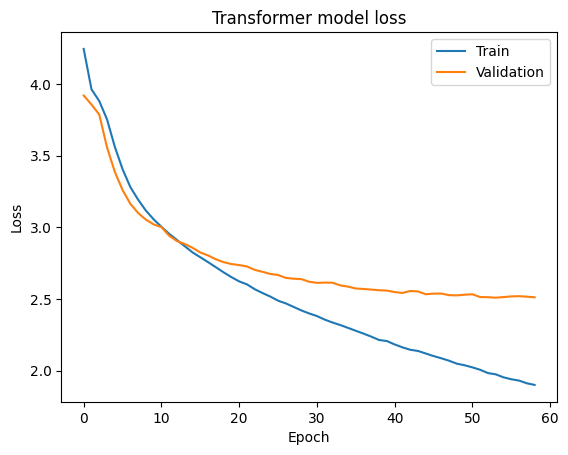

In [236]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Transformer model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Transformer model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

## CNN/RNN model

In [238]:
tokenizer = Tokenizer(num_words=None, filters='', lower=False)
def fit_tokenizer(texts):
    """Fit the tokenizer on the LaTeX text corpus."""
    tokenizer.fit_on_texts(texts)
    vocab_size = len(tokenizer.word_index) + 1
    # max_seq_length = max(len(seq) for seq in tokenizer.texts_to_sequences(texts))
    acutal_max_seq_length = max(len(seq) for seq in tokenizer.texts_to_sequences(texts))
    assert max_seq_length >= acutal_max_seq_length,  f"max_seq_length ({max_seq_length}) should be greater than or equal to acutal_max_seq_length ({acutal_max_seq_length})"
    print(f"Vocabulary size: {vocab_size}, Max sequence length: {max_seq_length}")
    return vocab_size, max_seq_length

def text_to_sequence(text):
    """Convert LaTeX text to a sequence of tokens."""
    return tokenizer.texts_to_sequences([text])[0]

def sequence_to_text(sequence):
    """Convert token sequence back to LaTeX text."""
    return tokenizer.sequences_to_texts([sequence])[0]
    

In [239]:
vocab_size, max_seq_length = fit_tokenizer(train_latex_texts)
train_sequences = prepare_sequences(train_latex_texts, max_seq_length)
max_seq_len1 = max_seq_length - 1
train_sequences = np.expand_dims(train_sequences, -1)
lstm_units = 256

Vocabulary size: 513, Max sequence length: 250


In [240]:
def build_cnn_encoder(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(EMBEDDING_DIM, activation='relu')(x)
    return Model(inputs, x)

In [242]:
def build_rnn_encoder(decoder_input, encoder_output, target_vocab_size, max_seq_len_1):

    embedding_layer = Embedding(input_dim=target_vocab_size, output_dim=EMBEDDING_DIM, input_length=max_seq_len_1)
    embedded_seq = embedding_layer(decoder_input)

    decoder_lstm_input = tf.keras.layers.Concatenate(axis=-1)([encoder_output, embedded_seq])
    decoder_lstm = LSTM(lstm_units, return_sequences=True)(decoder_lstm_input)
    decoder_output = TimeDistributed(Dense(target_vocab_size, activation="softmax"))(decoder_lstm)

    return Model(inputs=[decoder_input, encoder_output], outputs= decoder_output)

In [243]:
def build_model(input_shape, target_vocab_size, max_seq_len_1):
    encoder = build_cnn_encoder(input_shape)
    image_input = Input(shape=input_shape, name="image_input")

    encoder_output = encoder(image_input)
    encoder_output = RepeatVector(max_seq_len_1)(encoder_output)  # Repeat encoder output for each time step

    decoder_input = Input(shape=(max_seq_len_1,), name="decoder_input")
    decoder = build_rnn_encoder(decoder_input, encoder_output, target_vocab_size, max_seq_len_1)
    decoder_output = decoder([decoder_input, encoder_output])
    return Model(inputs=[image_input, decoder_input], outputs=decoder_output)

In [244]:
model = build_model([50, 200, 1], vocab_size, max_seq_len_1)
#transformer_model = Transformer(tokenizer, output_layer=output_layer, units=128, dropout_rate=0.5, num_layers=2, num_heads=2)

In [245]:
model.summary()

Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_input (InputLayer)    [(None, 50, 200, 1)]         0         []                            
                                                                                                  
 model_18 (Functional)       (None, 256)                  5008128   ['image_input[0][0]']         
                                                                                                  
 decoder_input (InputLayer)  [(None, 249)]                0         []                            
                                                                                                  
 repeat_vector_4 (RepeatVec  (None, 249, 256)             0         ['model_18[0][0]']            
 tor)                                                                                      

In [247]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#tf.keras.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=10,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored metric
)

In [248]:
print(train_sequences[:, :-1].shape)
print(train_sequences[:, 1:].shape)
print(train_sequences.shape)
# print(train_sequences[0])

(50000, 249, 1)
(50000, 249, 1)
(50000, 250, 1)


In [249]:
history = model.fit([train_images, train_sequences[:, :-1]],
          train_sequences[:, 1:],
          epochs=100,
          validation_split = 0.2,
          batch_size=128, callbacks = [early_stopping])


Epoch 1/100
313/313 [==============================] - 25s 72ms/step - loss: 1.0337 - accuracy: 0.8055 - val_loss: 0.8003 - val_accuracy: 0.8388
Epoch 2/100
313/313 [==============================] - 18s 59ms/step - loss: 0.7396 - accuracy: 0.8450 - val_loss: 0.6911 - val_accuracy: 0.8546
Epoch 3/100
313/313 [==============================] - 18s 59ms/step - loss: 0.6724 - accuracy: 0.8584 - val_loss: 0.6476 - val_accuracy: 0.8630
Epoch 4/100
313/313 [==============================] - 19s 59ms/step - loss: 0.6345 - accuracy: 0.8650 - val_loss: 0.6113 - val_accuracy: 0.8699
Epoch 5/100
313/313 [==============================] - 18s 59ms/step - loss: 0.5985 - accuracy: 0.8724 - val_loss: 0.5780 - val_accuracy: 0.8760
Epoch 6/100
313/313 [==============================] - 19s 59ms/step - loss: 0.5647 - accuracy: 0.8780 - val_loss: 0.5510 - val_accuracy: 0.8804
Epoch 7/100
313/313 [==============================] - 19s 59ms/step - loss: 0.5350 - accuracy: 0.8831 - val_loss: 0.5212 - val_ac

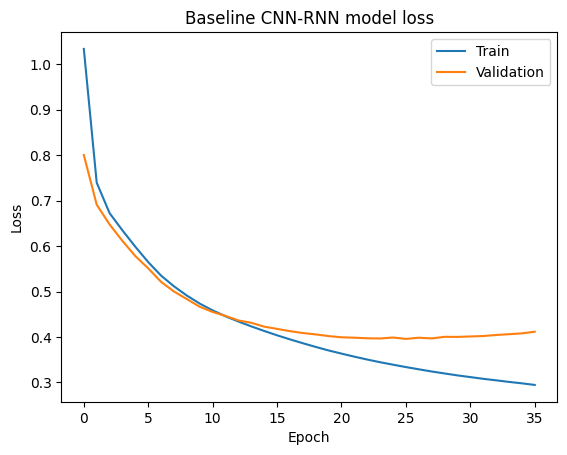

In [251]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Baseline CNN-RNN model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

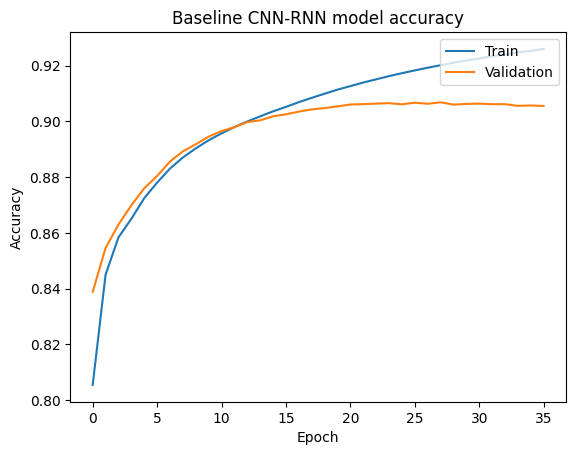

In [252]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Baseline CNN-RNN model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [253]:
model.save('baseline.keras')

# Model Training

In [ ]:
with tf.device('/GPU:0'):
    model.fit([train_images, train_sequences[:, :-1]],
              train_sequences[:, 1:],
              epochs=20,
              batch_size=128,
              validation_split=0.2)

from tensorflow.keras.models import load_model
model.save('/home/ubuntu/latex_model.keras')

#model = load_model('latex_model.h5')


In [ ]:
#dot_img_file =
import keras
keras.utils.plot_model(model,
                       show_shapes=True,
                       show_dtype=True,
                       show_layer_names=True,
                       expand_nested=True,
                       show_layer_activations=True,
                       )

In [ ]:
import keras
keras.utils.plot_model(model,
                       show_shapes=True,
                       show_dtype=True,
                       show_layer_names=True,
                       expand_nested=True,
                       show_layer_activations=True,
                       to_file='/Users/jayaprakash/latex_model.png'
                       )

# Predict

In [ ]:
import numpy as np

def predict_latex_sequence(model, image, tokenizer):
    """
    Predict LaTeX sequence from a single image.

    Parameters:
    - model: Trained Keras model for predicting LaTeX sequence.
    - image: Input image (preprocessed to match training dimensions).
    - tokenizer: Tokenizer fitted on LaTeX sequences for decoding predictions.
    - max_seq_len: Maximum sequence length for the predicted sequence.

    Returns:
    - latex_sequence: Predicted LaTeX sequence as a string.
    """
    # Prepare input image and initialize the sequence
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    start_token = tokenizer.word_index["<START>"]
    end_token = tokenizer.word_index["<END>"]

    # Initial sequence with the start token
    sequence = [start_token]

    for _ in range(max_seq_len_1):
        # Pad the current sequence to match input length
        padded_sequence = np.pad(sequence, (0, max_seq_len_1 - len(sequence)), mode='constant')
        padded_sequence = np.expand_dims(padded_sequence, axis=0)  # Add batch dimension

        # Predict next token
        preds = model.predict([image, padded_sequence])
        next_token = np.argmax(preds[0, len(sequence) - 1, :])

        # Break if end token is reached
        if next_token == end_token:
            break

        # Add the predicted token to the sequence
        sequence.append(next_token)

    # Decode the token sequence to a string
    latex_sequence = tokenizer.sequences_to_texts([sequence[1:]])[0]  # Skip the start token
    return latex_sequence

predicted_latex = predict_latex_sequence(model, train_images[12], tokenizer)
print("Predicted LaTeX:", predicted_latex)
#print("Original Seq:", train_sequences[0])
print("Original Seq:", train_latex_texts[12])